# Сборный проект 2

Менеджеры испугались, что дизайнеры сломают все воронки приложения, и попросили провести анализ результатов A/A/B-тестирования, чтобы принятие решения относительно изменений дизайна было обоснованным.

## Структура проекта
1. [Начало](#inception)
1. [Предобработка](#preprocessing)
1. [Анализ](#analisys)
1. [Выводы](#conclusions)

## Начало
<a id='inception' name='inception'></a>
We need to go deeper

In [33]:
from os import environ
import re

import pandas as pd
import numpy as np
from scipy import stats as st

from warnings import filterwarnings
filterwarnings('ignore')

In [34]:
pd.set_option(
    'display.float_format', lambda x: '%.3f' % x
)

In [35]:
def read_csv(func: 'pd.read_csv'=pd.read_csv) ->pd.DataFrame:
    """Wrapper for pd.read_csv."""
    def wrapper(*args, **kwargs: 'pd.read_csv parameters') -> pd.DataFrame:
        """
        Return a DataFrame from csv with true and ordered columns and sort by
        datetime, and display 5 randow rows and df.info().
        """
        df = func(*args, **kwargs)
        

        if kwargs.get('names', None) is None:
            df.columns = [
                re.sub('([a-z])([A-Z]+)', r'\1_\2', col).strip().lower().replace(' ', '_') 
                for col 
                in df.columns
                ]

        parse_dates = kwargs.get('parse_dates', None)
        if parse_dates is not None and df.select_dtypes('datetime').isnull:
            df.iloc[:, parse_dates[0]] = pd.to_datetime(df.iloc[:, parse_dates[0]], unit='s')

        if not df.select_dtypes('datetime').isnull:
            date_column = df.select_dtypes('datetime').columns[0]
            df = df.sort_values(date_column).reset_index(drop=True)

        columns_indeces = kwargs.get(
            'usecols', 
            np.arange(df.shape[1])
        )
        df = df.iloc[:, columns_indeces]
        
        display(
            df.sample(5, random_state=42).sort_index()
        )
        print()
        df.info(memory_usage='deep')

        return df
    return wrapper

true_read_csv = read_csv()

In [36]:
try:
    PATH = environ['LOGS_EXP']
except KeyError:
    PATH = '/datasets/logs_exp.csv'

data = true_read_csv(
    filepath_or_buffer = PATH, 
    sep='\t',
    names = ['event', 'id', 'ts', 'group'],
    parse_dates = [2],
    skiprows = [0],
    dtype = {
        3: 'category', 
        0: 'category'
        },
    usecols = [2, 0, 1, 3]
)

,ts,event,id,group
16881,2019-08-01 11:36:38,CartScreenAppear,197027893265565660,246
33362,2019-08-01 18:14:01,MainScreenAppear,3008457239613772584,248
100536,2019-08-03 16:44:30,PaymentScreenSuccessful,2910761286178294850,248
222854,2019-08-07 09:55:33,MainScreenAppear,499118262689586521,247
243827,2019-08-07 20:41:35,MainScreenAppear,4164287718073415198,246



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ts      244126 non-null  datetime64[ns]
 1   event   244126 non-null  category      
 2   id      244126 non-null  int64         
 3   group   244126 non-null  category      
dtypes: category(2), datetime64[ns](1), int64(1)
memory usage: 4.2 MB


Пропусков нет, типы данных нормальные.

---

## Предобработка
<a id='preprocessing' name='preprocessing'></a>
Предобработаем их хорошенько

Для начала проверим данные на самые грубые дубликаты:

In [37]:
data.duplicated().mean()

0.0016917493425526163

Меньше пятой части процента. Удалим их:

In [38]:
data = data.drop_duplicates().reset_index(drop=True)

Продолжим поиском мусора по столбцам.
<br>
События:

In [39]:
data['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

С событиями всё в норме.
<br>
Проверим группы:

In [40]:
data.groupby('group').agg(
    pct=('id', lambda x: x.nunique() / data['id'].nunique()), 
    nunique=('id', 'nunique'), 
    count=('id', 'count')
    )

,pct,nunique,count
group,,,
246,0.330,2489,80181
247,0.334,2520,77950
248,0.337,2542,85582


Заодно проверили корректность разбиения пользователей на группы.
<br>
Отклонения в рамках допустимого, мусора нет.
<br>
Пойдём дальше:

In [41]:
data['ts'].agg(['min', 'max'])

min   2019-07-25 04:43:36
max   2019-08-07 21:15:17
Name: ts, dtype: datetime64[ns]

Имеем данные за 07/25 - 08/07. 
<br>
Взглянем дополнительно на респределение данных по часам:

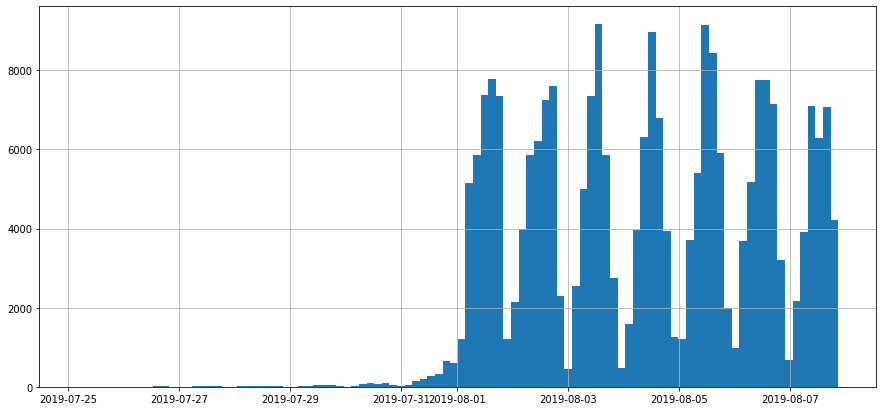

In [42]:
data['ts'].astype('datetime64[h]').hist(bins=100, figsize=(15, 7))

Видно, что полноценные данные имеются только для первой недели августа. 
<br>
Отфильтруем лишнее:

In [43]:
df = data[data['ts'] >= '2019-08-01'].reset_index(drop=True)
(df['id'].nunique() / data['id'].nunique()) - 1

-0.0022513574361011646

In [44]:
(df['event'].count() / data['event'].count()) - 1

-0.01159560630741896

Исключили всего 1% событий и меньше половины процента пользователей.

In [45]:
df['id'].value_counts().describe()

count   7534.000
mean      31.973
std       65.090
min        1.000
25%        9.000
50%       19.000
75%       37.000
max     2307.000
Name: id, dtype: float64

Видно, что распределение количества действий на пользователя перекошено влево, из-за чего среднее количество действий почти в два раза больше медианного. 

In [46]:
df.groupby('id')['event'].first().value_counts(normalize=True)

MainScreenAppear          0.837
Tutorial                  0.104
OffersScreenAppear        0.038
PaymentScreenSuccessful   0.013
CartScreenAppear          0.008
Name: event, dtype: float64

Имеем 5% *id*, первое событие для которых не *MainScreenAppear* или *Tutorial*. В принципе, такое вполне может быть, потому что у нас в качестве идентификатора используется *device_id*, но лучше удалить такие *id*, потому что они исказят картину:

In [47]:
df = df.groupby('id').filter(lambda x: x.iloc[0, 1] in ['MainScreenAppear', 'Tutorial']).reset_index(drop=True)

Проверим так же вхождение пользователей сразу в несколько групп:

In [48]:
(df.groupby('id')['group'].nunique() != 1).sum()

0

Всё чисто.
<br>
Перейдём к анализу.

---

## Анализ
<a id='analisys' name='analisys'></a>
Посмотрим на разные штуки

События по числу пользователей:

In [49]:
df.groupby('event')['id'].nunique().sort_values(ascending=False)

event
MainScreenAppear           7084
OffersScreenAppear         4147
CartScreenAppear           3326
PaymentScreenSuccessful    3138
Tutorial                    830
Name: id, dtype: int64

Относительное количество событий:

In [50]:
df['event'].value_counts(normalize=True)

MainScreenAppear          0.520
OffersScreenAppear        0.182
CartScreenAppear          0.164
PaymentScreenSuccessful   0.130
Tutorial                  0.005
Name: event, dtype: float64

In [51]:
(df.groupby('id')['event'].agg('nunique') == 5).mean()

0.06461625282167043

Всего 6% пользователей прошли через все 5 действий.
<br>
Очевидно, что действия расположены по порядку, но *Tutorial* тут лишний.
<br>
Уберём его:

In [52]:
(df.query("event != 'Tutorial'").groupby('id')['event'].agg('nunique') == 4).mean()

0.4414172783738001

Получается, почти половина всех пользователей достигла того, чего хотела.
<br>
Посмотрим на конверсию из предыдущего шага и из начала:

In [53]:
cr = df.groupby('event').agg(cr_step=('id', 'nunique')).sort_values('cr_step', ascending=False).pct_change() + 1
cr['cr'] = cr['cr_step'].cumprod()
cr.fillna(1).iloc[:4]

,cr_step,cr
event,,
MainScreenAppear,1.000,1.000
OffersScreenAppear,0.585,0.585
CartScreenAppear,0.802,0.470
PaymentScreenSuccessful,0.943,0.443


Больше всех пользователей теряется на этапе выбора товара (почти половина).
<br>
До оплаты доходит почти половина всех пользователей (44%)

---

Напишем функцию для определения результатов Z-теста для двух выборок:

In [54]:
def two_sample_z_test(
    A: {'type': list, 'help': 'total and success counts from sample A'}, 
    B: {'type': list, 'help': 'total and success counts from sample B'}
    ) ->{'type': float, 'help': 'p-value for z-test'}:
    """Return p-value for two-sample z-test."""
    p1 = A[1] / A[0]
    p2 = B[1] / B[0]
    p = (A[1] + B[1]) / (A[0] + B[0])
    
    z_value = (p1 - p2) / np.sqrt(p * (1 - p) * (1/A[0] + 1/B[0]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return '{:.3f}'.format(p_value)

In [55]:
two_sample_z_test(
    [2331, 1061],
    [2357, 1022]
)

'0.137'

Соберём сводную таблицу с информацией по всем группам:

In [56]:
group_pivot = df.query("event != 'Tutorial'").pivot_table(
    index = 'event',
    columns = 'group',
    values = 'id',
    aggfunc = 'nunique',
    observed = True,
)
group_pivot

group,246,247,248
event,,,
MainScreenAppear,2331,2357,2396
OffersScreenAppear,1390,1365,1392
CartScreenAppear,1125,1098,1103
PaymentScreenSuccessful,1061,1022,1055


А ещё заодно посмотрим на конверсии по группам:

In [57]:
group_pivot.apply(lambda x: x / x[0])

group,246,247,248
event,,,
MainScreenAppear,1.000,1.000,1.000
OffersScreenAppear,0.596,0.579,0.581
CartScreenAppear,0.483,0.466,0.460
PaymentScreenSuccessful,0.455,0.434,0.440


На первый взгляд, тестовая группа не имеет никаких отличий по сравнению с контрольными группами. 
<br>
Проверим, так ли это. Для окончательно убедимся в корректности проведения эксперимента, сравнив показатели двух контрольных групп:

$H_0 - Конверсия\ в\ покупку\ в\ одной\ контрольной\ группе\ не\ имеет\ статистически\ значимых\ отличий\ от\ конверсии\ в\ покупку\ в\ другой\ контрольной\ группе$
<br>
$H_1 - Конверсия\ в\ одной\ контрольной\ группе\ имеет\ статистически\ значимые\ отличия\ от\ конверсии\ в\ другой\ контрольной\ группе$
<br>
$\alpha = 5\%$

In [58]:
two_sample_z_test(
    [group_pivot.iloc[0, 0], group_pivot.iloc[3, 0]], 
    [group_pivot.iloc[0, 1], group_pivot.iloc[3, 1]]
    )

'0.137'

При 5% статистической значимости нет оснований отклонять нулевую гипотезу. 
<br>
Другими словами, обе тестовые группы **не имеют статистически значимых отличий**.
<br>
Посмотрим на **конверсии в другие события**:

$H_0 - Конверсия\ в\ событие\ в\ одной\ контрольной\ группе\ не\ имеет\ статистически\ значимых\ отличий\ от\ конверсии\ в\ событие\ в\ другой\ контрольной\ группе$
<br>
$H_1 - Конверсия\ в\ событие\ в\ одной\ контрольной\ группе\ имеет\ статистически\ значимые\ отличия\ от\ конверсии\ в\ событие\ в\ другой\ контрольной\ группе$
<br>
$\alpha = 5\%$

In [59]:
for event in group_pivot.index[1:]:
    A1 = [
        group_pivot.loc['MainScreenAppear', '246'], 
        group_pivot.loc[event, '246']
        ]
    A2 = [
        group_pivot.loc['MainScreenAppear', '247'], 
        group_pivot.loc[event, '247']
    ]
    print(f'p-value для {event}: {two_sample_z_test(A1, A2)}')

p-value для OffersScreenAppear: 0.232
p-value для CartScreenAppear: 0.250
p-value для PaymentScreenSuccessful: 0.137


Для всех событий тестовые группы не имеют между собой никаких отличий. Проведение эксперимента было корректным.
<br>
Сравним теперь тестовую группу с одной из контрольных:

$H_0 - Конверсия\ в\ событие\ в\ тестовой\ группе\ не\ имеет\ статистически\ значимых\ отличий\ от\ конверсии\ в\ событие\ в\ контрольной\ группе$
<br>
$H_1 - Конверсия\ в\ событие\ в\ тестовой\ группе\ имеет\ статистически\ значимые\ отличия\ от\ конверсии\ в\ событие\ в\ контрольной\ группе$
<br>
$\alpha = 5\%$

In [60]:
for event in group_pivot.index[1:]:
    A = [
        group_pivot.loc['MainScreenAppear', '246'], 
        group_pivot.loc[event, '246']
        ]
    B = [
        group_pivot.loc['MainScreenAppear', '248'], 
        group_pivot.loc[event, '248']
    ]
    print(f'p-value для {event}: {two_sample_z_test(A, B)}')

p-value для OffersScreenAppear: 0.284
p-value для CartScreenAppear: 0.125
p-value для PaymentScreenSuccessful: 0.305


И с другой:

$H_0 - Конверсия\ в\ событие\ в\ тестовой\ группе\ не\ имеет\ статистически\ значимых\ отличий\ от\ конверсии\ в\ событие\ в\ другой\ контрольной\ группе$
<br>
$H_1 - Конверсия\ в\ событие\ в\ тестовой\ группе\ имеет\ статистически\ значимые\ отличия\ от\ конверсии\ в\ событие\ в\ другой\ контрольной\ группе$
<br>
$\alpha = 5\%$

In [61]:
for event in group_pivot.index[1:]:
    A = [
        group_pivot.loc['MainScreenAppear', '247'], 
        group_pivot.loc[event, '247']
        ]
    B = [
        group_pivot.loc['MainScreenAppear', '248'], 
        group_pivot.loc[event, '248']
    ]
    print(f'p-value для {event}: {two_sample_z_test(A, B)}')

p-value для OffersScreenAppear: 0.898
p-value для CartScreenAppear: 0.704
p-value для PaymentScreenSuccessful: 0.641


Сравним так же тестовую группу с **объединённой контрольной группой**:

$H_0 - Конверсия\ в\ событие\ в\ тестовой\ группе\ не\ имеет\ статистически\ значимых\ отличий\ от\ конверсии\ в\ событие\ в\ объединённой\ контрольной\ группе$
<br>
$H_1 - Конверсия\ в\ событие\ в\ тестовой\ группе\ имеет\ статистически\ значимые\ отличия\ от\ конверсии\ в\ событие\ в\ объединённой\ контрольной\ группе$
<br>
$\alpha = 5\%$

In [62]:
for event in group_pivot.index[1:]:
    A = [
        group_pivot.loc['MainScreenAppear', '247'] + group_pivot.loc['MainScreenAppear', '246'], 
        group_pivot.loc[event, '247'] + group_pivot.loc[event, '246']
        ]
    B = [
        group_pivot.loc['MainScreenAppear', '248'], 
        group_pivot.loc[event, '248']
    ]
    print(f'p-value для {event}: {two_sample_z_test(A, B)}')

p-value для OffersScreenAppear: 0.588
p-value для CartScreenAppear: 0.270
p-value для PaymentScreenSuccessful: 0.748


Все результаты сильно выше уровня статистической значимости ($\alpha = 5\%$). Если делать поправку на количество проведённых экспериментов, порог отклонения нулевой гипотезы будет ещё ниже (при использовании самой простой поправки на множественное тестирование - *поправку Бонферрони* - уровень статистической значимости нужно разделить на количество проведённых тестирований, в нашем случае - **6** для сравнения каждого события между обеими контрольными группами и тестовой, и **3** - для сравнения каждого события между объединённой контрольной и тестовой группой).
<br>
Даже если изменить $\alpha$ - ничего не изменится

---

## Выводы
<a name='conclusions' id='conclusions'></a>
Подведём итоги

Проведя анализ результатов эксперимента, можно с уверенностью заявить - менеджеры зря боялись за привычки пользователей - шрифт покупкам не помеха. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73c6fdc9-2380-4d92-b495-95da9dd36eb1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>